# 0. Import the Dataset

In [20]:
import pandas as pd

df = pd.read_csv("train.csv")
df = df.drop(columns=['id'])
df = df.rename(columns={'Temparature': 'Temperature'})
df.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


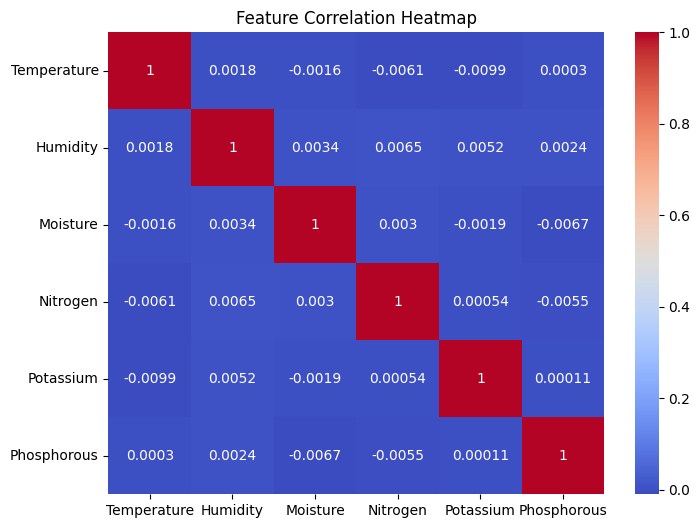

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [22]:
df['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

## Observations
Imbalanced classes. <br>
Very low correlations, no PCA needed.

# 1. Data Preprocessing

## Check Nulls

In [23]:
df.isnull().sum()

Temperature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

## Encode

In [24]:
from sklearn.preprocessing import OneHotEncoder

def ohe_and_replace(df, column_name):
    ohe = OneHotEncoder(sparse_output=False)
    encoded = ohe.fit_transform(df[[column_name]]).astype(int)
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([column_name]))
    col_idx = df.columns.get_loc(column_name)
    df_wo_col = df.drop(column_name, axis=1)
    df = pd.concat([
        df_wo_col.iloc[:, :col_idx].reset_index(drop=True),
        encoded_df.reset_index(drop=True),
        df_wo_col.iloc[:, col_idx:].reset_index(drop=True)
    ], axis=1)
    return df

df = ohe_and_replace(df, 'Soil Type')
df = ohe_and_replace(df, 'Crop Type')

df.head()

,Temperature,Humidity,Moisture,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,Soil Type_Sandy,Crop Type_Barley,Crop Type_Cotton,...,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,0,1,0,0,0,0,0,...,0,0,0,1,0,0,36,4,5,28-28
1,27,69,65,0,0,0,0,1,0,0,...,0,0,0,0,0,0,30,6,18,28-28
2,29,63,32,0,0,0,0,1,0,0,...,0,0,0,0,0,0,24,12,16,17-17-17
3,35,62,54,0,0,0,0,1,1,0,...,0,0,0,0,0,0,39,12,4,10-26-26
4,35,58,43,0,0,0,1,0,0,0,...,0,1,0,0,0,0,37,2,16,DAP


## Normalize

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_columns = ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,Temperature,Humidity,Moisture,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,Soil Type_Sandy,Crop Type_Barley,Crop Type_Cotton,...,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0.923077,0.909091,0.275,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.842105,0.210526,0.119048,28-28
1,0.153846,0.863636,1.000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.684211,0.315789,0.428571,28-28
2,0.307692,0.590909,0.175,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.526316,0.631579,0.380952,17-17-17
3,0.769231,0.545455,0.725,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0.921053,0.631579,0.095238,10-26-26
4,0.769231,0.363636,0.450,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0.868421,0.105263,0.380952,DAP


# 2. Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Fertilizer Name'])
y = df['Fertilizer Name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# 3. Class Weights

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights = dict(zip(np.unique(y), class_weights))

# 4. Model Training

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
importances = []

for train_idx, val_idx in kf.split(X, y):
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    importances.append(clf.feature_importances_)

mean_importances = np.mean(importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                  Feature  Importance
21            Phosphorous    0.175262
19               Nitrogen    0.173069
2                Moisture    0.164203
1                Humidity    0.156141
20              Potassium    0.140669
0             Temperature    0.134610
6           Soil Type_Red    0.004898
8        Crop Type_Barley    0.004476
12      Crop Type_Millets    0.004417
13    Crop Type_Oil seeds    0.004220
11        Crop Type_Maize    0.004174
7         Soil Type_Sandy    0.004101
5         Soil Type_Loamy    0.004057
9        Crop Type_Cotton    0.003955
3         Soil Type_Black    0.003939
14        Crop Type_Paddy    0.003791
17      Crop Type_Tobacco    0.003769
18        Crop Type_Wheat    0.003165
4        Soil Type_Clayey    0.002787
10  Crop Type_Ground Nuts    0.002055
15       Crop Type_Pulses    0.001193
16    Crop Type_Sugarcane    0.001050


In [33]:
filtered_feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.005]

In [34]:
from sklearn.model_selection import cross_val_score 
classes = np.unique(y)
class_weights = dict(zip(classes, class_weights))

important_features = filtered_feature_importance_df['Feature'].tolist()
X_important = X[important_features]


X_train_important, X_test_important, y_train_important, y_test_important = train_test_split(
    X_important, y, test_size=0.2, stratify=y
)

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation scores: [0.16334167 0.16249167 0.163725   0.16476667 0.16315833]
Mean CV accuracy: 0.16349666666666668
